# [Домашнє завдання до модуля «Алгоритми навчання з вчителем Ч.1»](https://www.edu.goit.global/uk/learn/25315460/23598278/23988991/homework)
___

## Імпорт необхідних модулів

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from scipy.stats import zscore

## 1. Завантаження даних

In [2]:
california_housing = fetch_california_housing()
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
data["PRICE"] = california_housing.target

FEATURES = data.columns[:-1].tolist()
TARGET = data.columns[-1]

print(f"Features: {FEATURES}")
print(f"Target: {TARGET}")
display(data.head(2))

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: PRICE


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


## 2. EDA

### Перевірка типів даних і відсутніх значень

- `MedInc`: cередній дохід населення відповідного кварталу (блоку будинків) у місті.
- `HouseAge`: середній вік будинку.
- `AveRooms`: середня кількість кімнат у будинку.
- `AveBedrms`: середня кількість спалень у будинку.
- `Population`: кількість населення кварталу.
- `AveOccup`: середня кількість зайнятих членів домогосподарства.
- `Latitude`: географічна широта (центральної точки) кварталу.
- `Longitude`: географічна довгота (центральної точки) кварталу.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Розподіл ознак

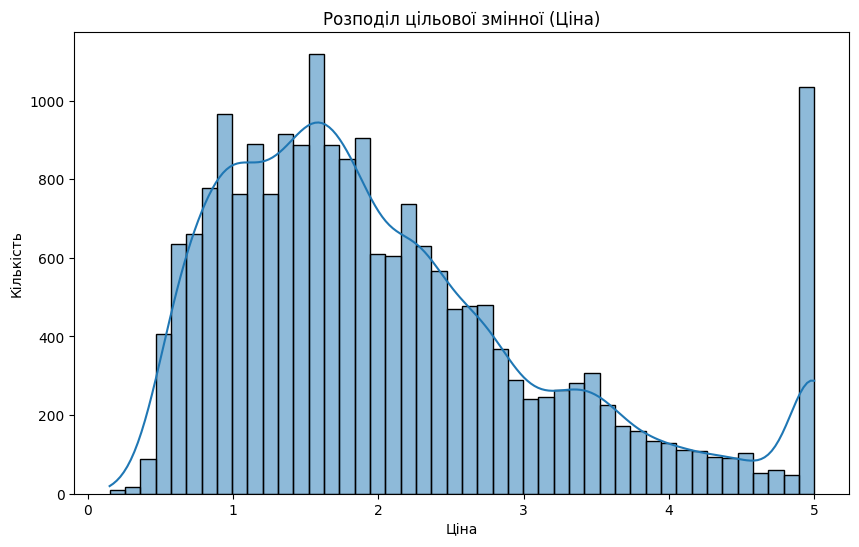

In [4]:
# Візуалізація початкового розподілу цільової змінної
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x=TARGET, kde=True)
plt.title("Розподіл цільової змінної (Ціна)")
plt.xlabel("Ціна")
plt.ylabel("Кількість")
plt.show()

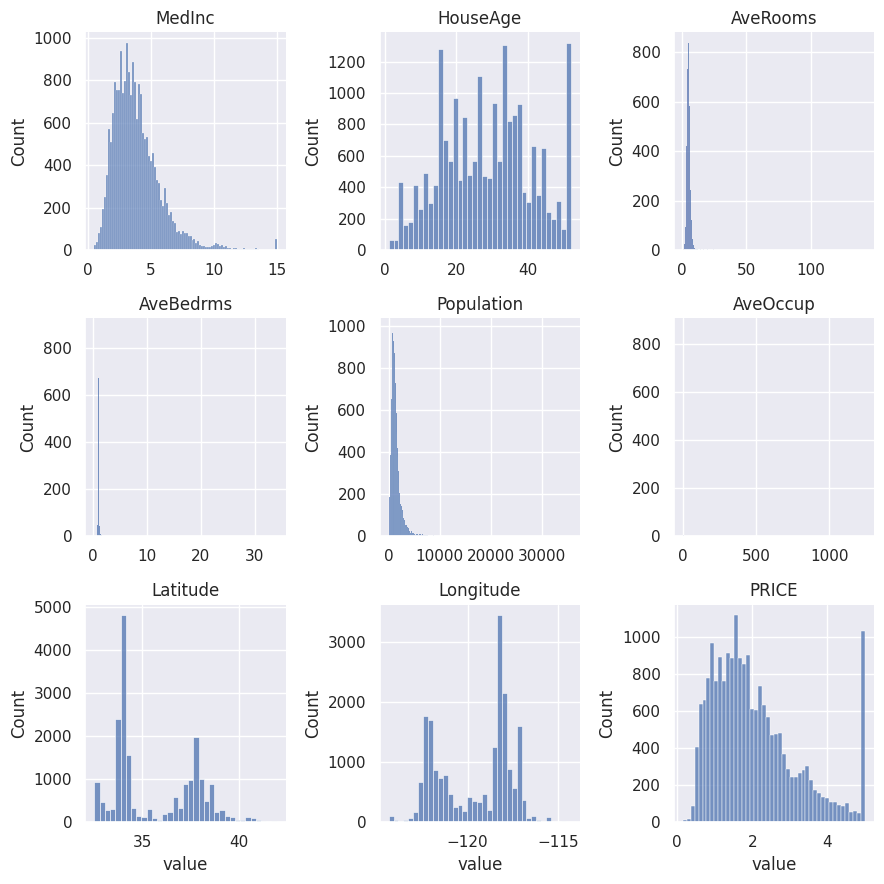

In [5]:
sns.set_theme()

g = sns.FacetGrid(data=data.melt(),
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')
g.tight_layout()

In [6]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Матриця кореляції датасету

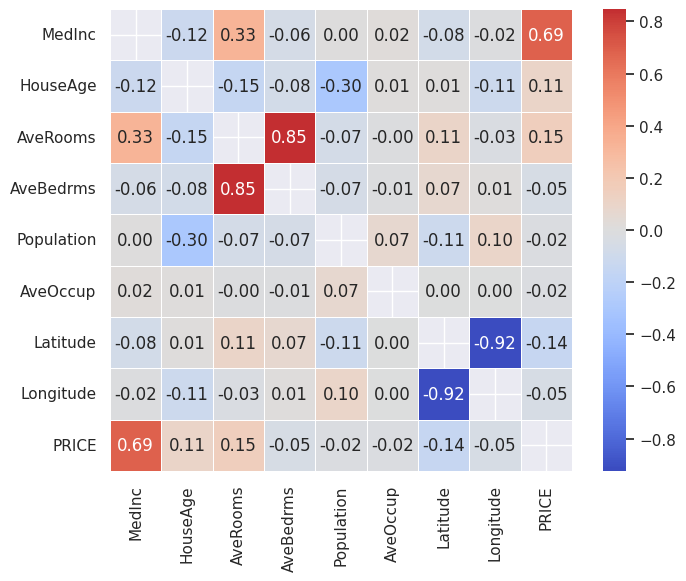

In [7]:
def visualize_correlation_matrix(df: pd.DataFrame, columns_of_interest=None) -> None:
    subset = df.copy() if columns_of_interest is None else df[columns_of_interest].copy()

    corr_mtx = subset.corr()

    mask_mtx = np.zeros_like(corr_mtx)
    np.fill_diagonal(mask_mtx, 1)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        corr_mtx,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        linewidth=0.5,
        square=True,
        mask=mask_mtx,
        ax=ax,
    )

visualize_correlation_matrix(data, FEATURES + [TARGET])

### Матриця кореляції після видалення `AveBedrms`
`AveRooms` та `AveBedrms` мають високу кореляцію (~0.85). 
Перевіримо матрицю без ознаки `AveBedrms`

['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


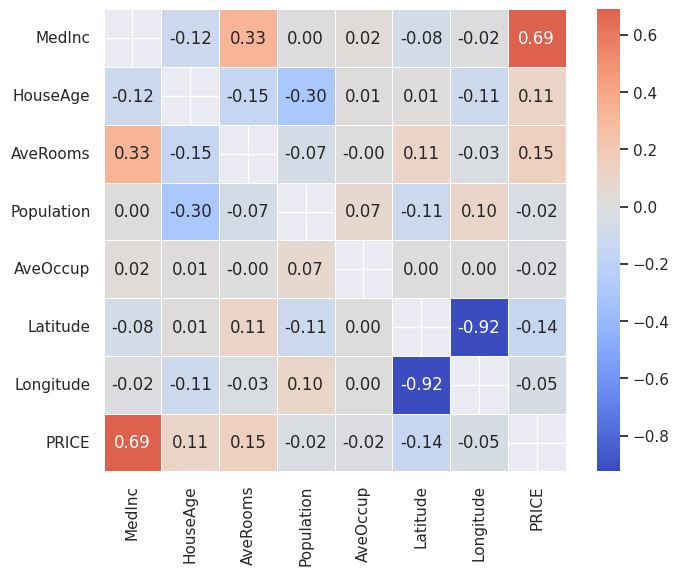

In [8]:
features_of_interest = FEATURES.copy()
features_of_interest.remove("AveBedrms")
print(features_of_interest)
visualize_correlation_matrix(data, features_of_interest+[TARGET])

Видалення `AveBedrms` допомогло зменшити мультиколінеарність. Отже, можемо оновити датасет.

Створюємо новий датасет з новим списком `features_of_interest`.

In [9]:
print(features_of_interest+[TARGET])
df_featured = data[features_of_interest + [TARGET]].copy()

data.head(2)

['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'PRICE']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


### Візуалізація геоданих

Text(0.5, 1.0, 'Середня вартість будинку в залежності від\n їхнього розташування')

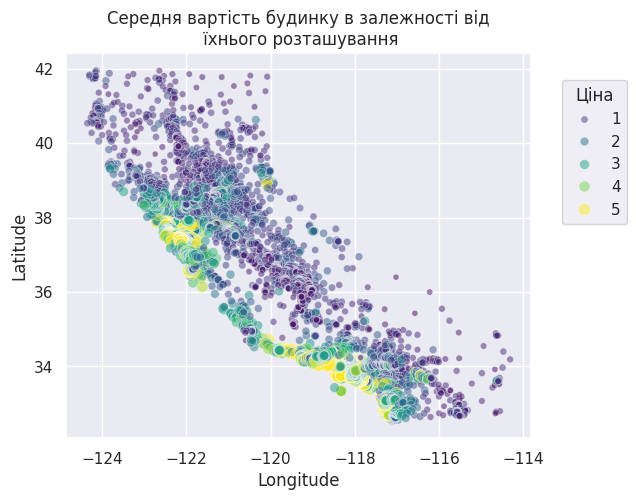

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df_featured,
    x="Longitude",
    y="Latitude",
    size=df_featured[TARGET],
    hue=df_featured[TARGET],
    palette="viridis",
    alpha=0.5,
    ax=ax,
)

plt.legend(title="Ціна", bbox_to_anchor=(1.05, 0.95), loc="upper left")

plt.title("Середня вартість будинку в залежності від\n їхнього розташування")

## 3. Попередня обробка даних

### Пошук викидів та обробка викидів

In [11]:
features_to_clean = ["AveRooms", "AveOccup", "Population"]

threshold = 3
z_scores = df_featured[features_to_clean].apply(zscore)
outliers = (abs(z_scores) > threshold).any(axis=1)

df_cleaned = df_featured[~outliers]

print("Оригінальні дані:", df_featured.shape)
print("Очищені дані:", df_cleaned.shape)

Оригінальні дані: (20640, 8)
Очищені дані: (20161, 8)


### Візуалізація результатів обробки

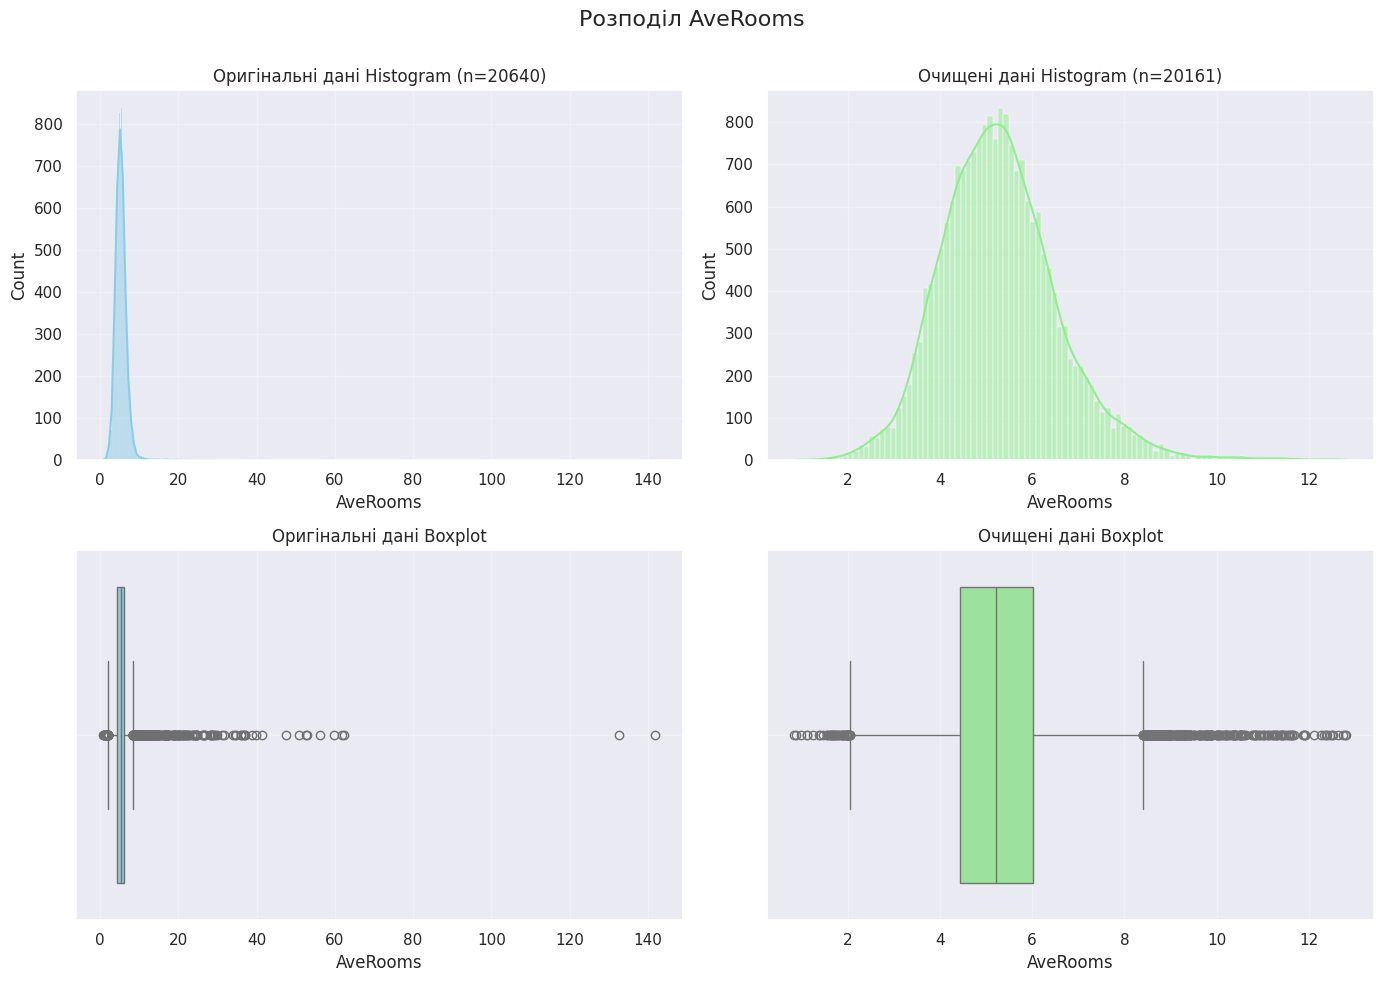


Статистика AveRooms:
        Оригінальні       очищені
count  20640.000000  20161.000000
mean       5.429000      5.296985
std        2.474173      1.284243
min        0.846154      0.846154
25%        4.440716      4.433962
50%        5.229129      5.214724
75%        6.052381      6.021622
max      141.909091     12.808511
--------------------------------------------------


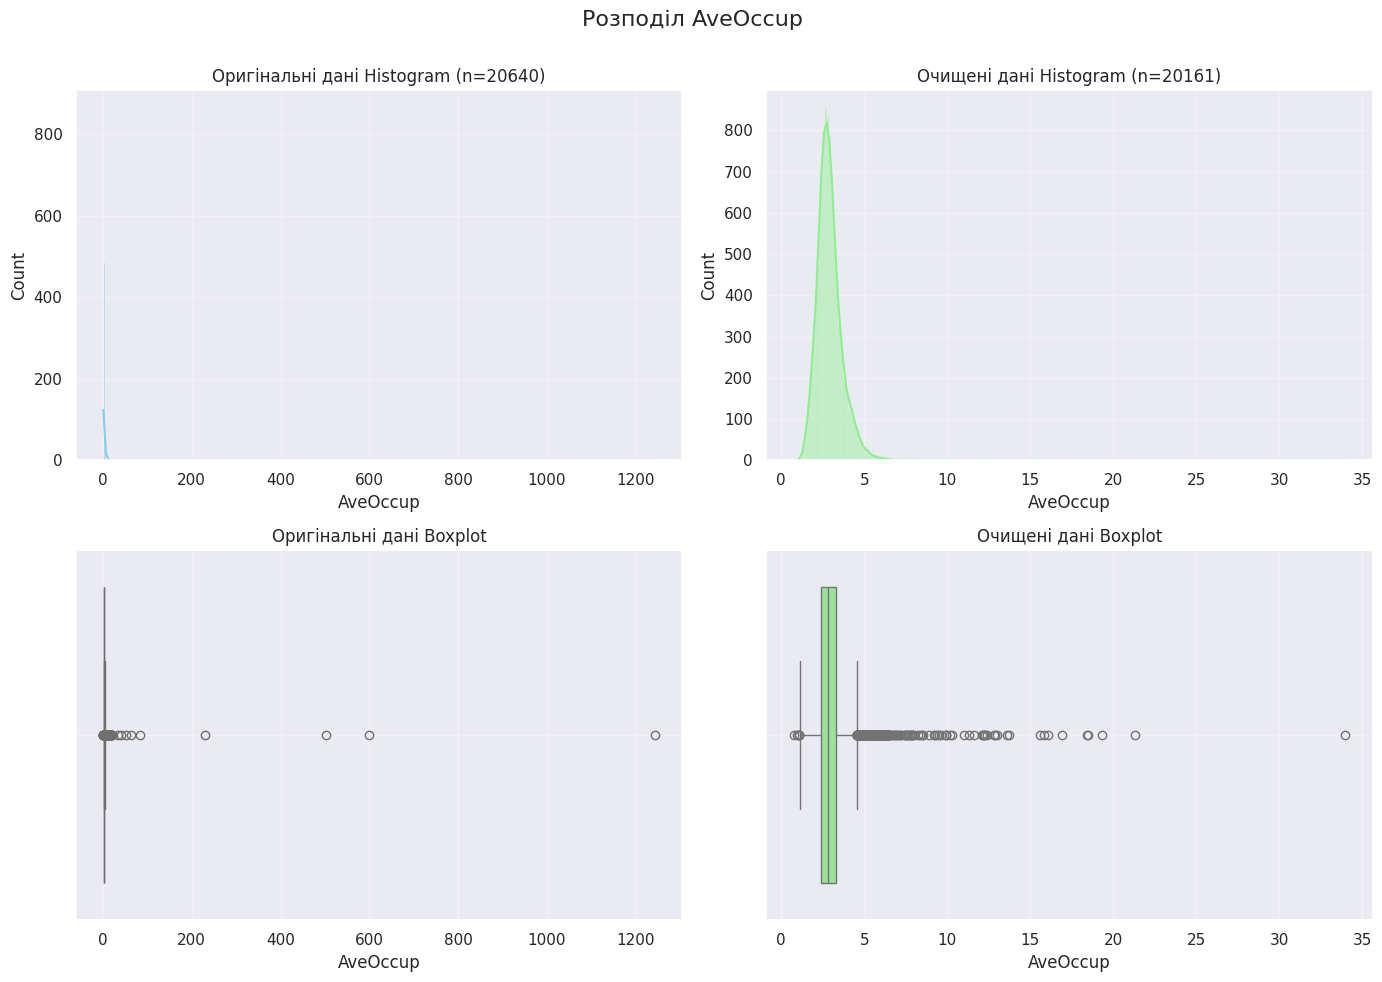


Статистика AveOccup:
        Оригінальні       очищені
count  20640.000000  20161.000000
mean       3.070655      2.930955
std       10.386050      0.885499
min        0.692308      0.750000
25%        2.429741      2.428571
50%        2.818116      2.817073
75%        3.282261      3.280079
max     1243.333333     33.952941
--------------------------------------------------


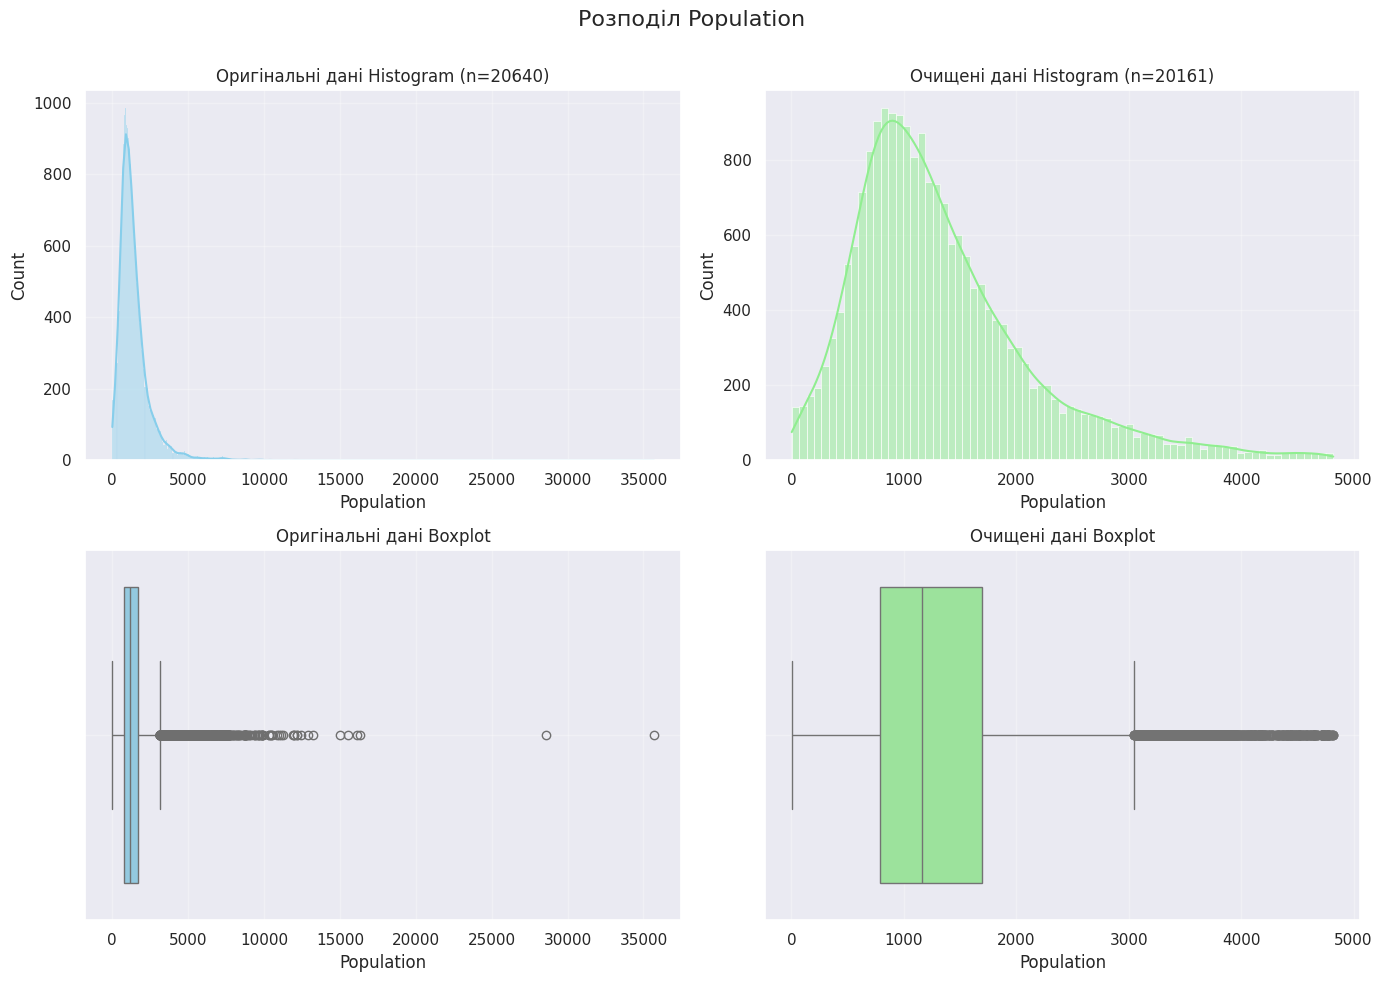


Статистика Population:
        Оригінальні       очищені
count  20640.000000  20161.000000
mean    1425.476744   1339.148753
std     1132.462122    812.747198
min        3.000000      3.000000
25%      787.000000    787.000000
50%     1166.000000   1158.000000
75%     1725.000000   1691.000000
max    35682.000000   4819.000000
--------------------------------------------------


In [12]:
for feature in features_to_clean:
    # original vs cleaned
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Розподіл {feature}', fontsize=16)

    sns.histplot(df_featured[feature], kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title(f'Оригінальні дані Histogram (n={df_featured.shape[0]})')
    axes[0, 0].grid(alpha=0.3)

    sns.boxplot(x=df_featured[feature], ax=axes[1, 0], color='skyblue')
    axes[1, 0].set_title("Оригінальні дані Boxplot")
    axes[1, 0].grid(alpha=0.3)

    sns.histplot(df_cleaned[feature], kde=True, ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title(f'Очищені дані Histogram (n={df_cleaned.shape[0]})')
    axes[0, 1].grid(alpha=0.3)

    sns.boxplot(x=df_cleaned[feature], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title("Очищені дані Boxplot")
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    print(f"\nСтатистика {feature}:")
    stats_df = pd.DataFrame({
        'Оригінальні': data[feature].describe(),
        'очищені': df_cleaned[feature].describe()
    })
    print(stats_df)
    print("-" * 50)

### Матриця кореляції змінних після очищення

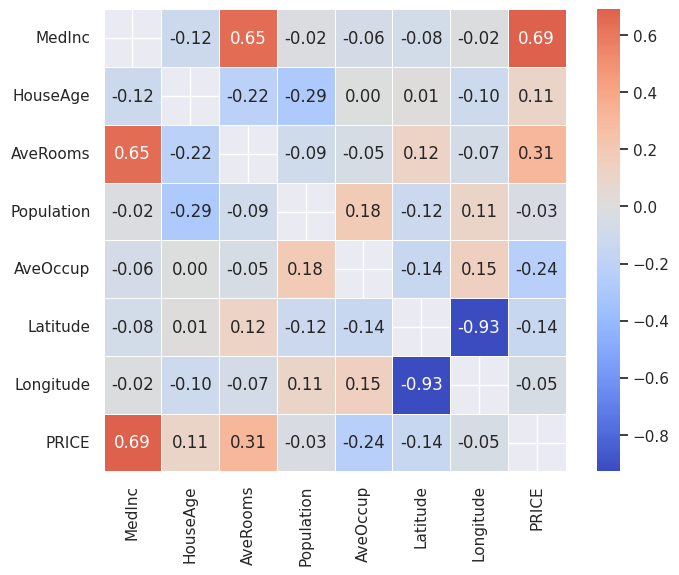

In [13]:
visualize_correlation_matrix(df_cleaned)

## 4. Підготовка даних для моделювання

### Розбиття на тренувальну і тестову вибірки

In [14]:
X = df_cleaned.drop(columns=[TARGET])
y = df_cleaned[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Нормалізація змінних

In [15]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude
count,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04
mean,2.718284e-16,-2.643388e-17,5.066494e-16,2.467162e-17,-1.927471e-16,9.480952e-16,3.647876e-15
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.765699e+00,-2.232851e+00,-3.470960e+00,-1.642094e+00,-2.461204e+00,-1.448268e+00,-2.348467e+00
25%,-6.852934e-01,-7.901241e-01,-6.718923e-01,-6.802825e-01,-5.639661e-01,-7.983272e-01,-1.112439e+00
50%,-1.775781e-01,1.139057e-02,-6.662465e-02,-2.239757e-01,-1.259013e-01,-6.440247e-01,5.422441e-01
75%,4.540242e-01,6.526024e-01,5.625601e-01,4.368083e-01,3.894198e-01,9.738129e-01,7.864593e-01
max,5.830816e+00,1.854874e+00,5.818959e+00,4.280056e+00,3.500506e+01,2.951690e+00,2.630534e+00


## 5. Навчання і оцінка моделі

In [16]:
def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes
    )
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Test")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

### Модель `LinearRegression`

In [17]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values
y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)

#### Оцінювання точності моделі

In [18]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}")

R²: 0.64 | MAE: 0.50 | MAPE: 0.30


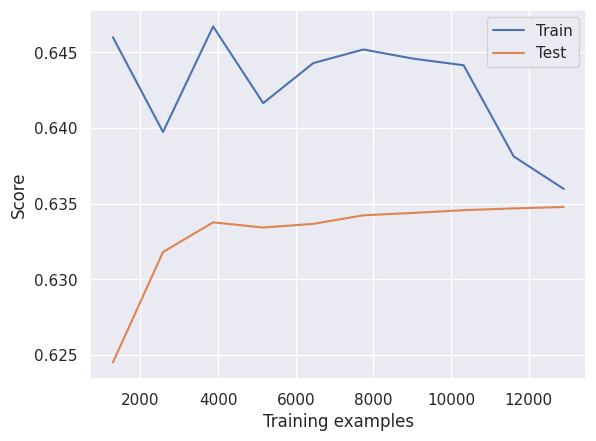

In [19]:
plot_learning_curve(model, X_train_scaled, y_train)

### Модель PolynomialFeatures

In [20]:
poly = PolynomialFeatures(2).set_output(transform="pandas")

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model_poly = LinearRegression().fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)
y_pred_poly = pd.Series(y_pred_poly, index=X_test_poly.index).clip(ymin, ymax)

#### Оцінювання точності моделі

In [21]:
r_sq_upd = model_poly.score(X_train_poly, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_poly)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f"R²: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")

R²: 0.70 | MAE: 0.45 | MAPE: 0.26


<Axes: xlabel='PRICE', ylabel='None'>

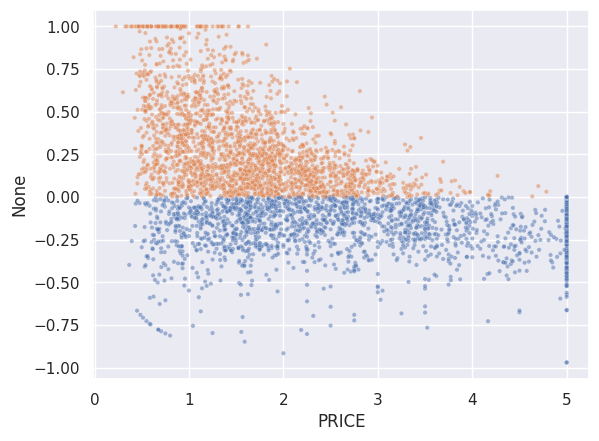

In [22]:
pct_error = (y_pred_poly / y_test - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test,
    y=pct_error,
    hue=pct_error.gt(0),
    alpha=0.5,
    s=10,
    legend=False)

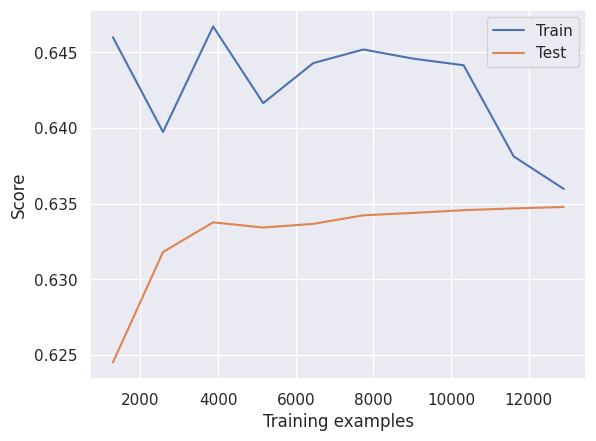

In [23]:
plot_learning_curve(model_poly, X_train_scaled, y_train)

## 6. Експерименти з створенням ознак

In [24]:
df_featured = df_cleaned.copy()

# Географічні ознаки
df_featured["Coast_Distance"] = np.abs(df_featured["Longitude"] + 124)
df_featured["Urban_Factor"] = df_featured["Population"] * df_featured["Coast_Distance"]

# Логарифмічні трансформації
df_featured["MedInc_log"] = np.log1p(df_featured["MedInc"])
df_featured["Population_log"] = np.log1p(df_featured["Population"])
df_featured["AveRooms_sqrt"] = np.sqrt(df_featured["AveRooms"])

# Цільові ознаки
# df_featured["Price_per_Room"] = df_featured[TARGET] / df_featured["AveRooms"]
# df_featured["Value_Density"] = df_featured[TARGET] / df_featured["Population"]

# Взаємодія ознак
df_featured["Income_Location"] = df_featured["MedInc"] * df_featured["Coast_Distance"]

df_featured.head(2)

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,PRICE,Coast_Distance,Urban_Factor,MedInc_log,Population_log,AveRooms_sqrt,Income_Location
0,8.3252,41.0,6.984127,322.0,2.555556,37.88,-122.23,4.526,1.77,569.94,2.232720,5.777652,2.642750,14.735604
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86,-122.22,3.585,1.78,4273.78,2.230165,7.784057,2.497626,14.776492


### Розбиття на тренувальну і тестову вибірки

In [25]:
X = df_featured.drop(columns=[TARGET])
y = df_featured[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X.head(2)

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,Coast_Distance,Urban_Factor,MedInc_log,Population_log,AveRooms_sqrt,Income_Location
0,8.3252,41.0,6.984127,322.0,2.555556,37.88,-122.23,1.77,569.94,2.232720,5.777652,2.642750,14.735604
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86,-122.22,1.78,4273.78,2.230165,7.784057,2.497626,14.776492


### Нормалізація змінних

In [26]:
scaler = StandardScaler().set_output(transform="pandas").fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,Coast_Distance,Urban_Factor,MedInc_log,Population_log,AveRooms_sqrt,Income_Location
count,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04,1.612800e+04
mean,2.718284e-16,-2.643388e-17,5.066494e-16,2.467162e-17,-1.927471e-16,9.480952e-16,3.647876e-15,-2.678633e-16,-3.524518e-18,1.572816e-16,-5.374889e-16,7.577713e-16,1.674146e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.765699e+00,-2.232851e+00,-3.470960e+00,-1.642094e+00,-2.461204e+00,-1.448268e+00,-2.348467e+00,-2.203746e+00,-1.209009e+00,-3.091583e+00,-8.089800e+00,-4.946383e+00,-1.424170e+00
25%,-6.852934e-01,-7.901241e-01,-6.718923e-01,-6.802825e-01,-5.639661e-01,-7.983272e-01,-1.112439e+00,-1.115272e+00,-7.388502e-01,-6.849342e-01,-4.840700e-01,-6.480287e-01,-7.477120e-01
50%,-1.775781e-01,1.139057e-02,-6.662465e-02,-2.239757e-01,-1.259013e-01,-6.440247e-01,5.422441e-01,5.424032e-01,-2.537369e-01,-1.539844e-02,7.279109e-02,-7.324301e-03,-2.487108e-01
75%,4.540242e-01,6.526024e-01,5.625601e-01,4.368083e-01,3.894198e-01,9.738129e-01,7.864593e-01,7.870602e-01,4.200260e-01,6.409839e-01,6.221349e-01,6.098629e-01,5.112756e-01
max,5.830816e+00,1.854874e+00,5.818959e+00,4.280056e+00,3.500506e+01,2.951690e+00,2.630534e+00,2.634470e+00,5.903904e+00,3.494764e+00,2.127717e+00,4.662753e+00,7.071464e+00


### Модель `LinearRegression`

In [27]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(["min", "max"]).values
y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)

#### Оцінювання точності моделі

In [28]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}")

R²: 0.65 | MAE: 0.49 | MAPE: 0.29


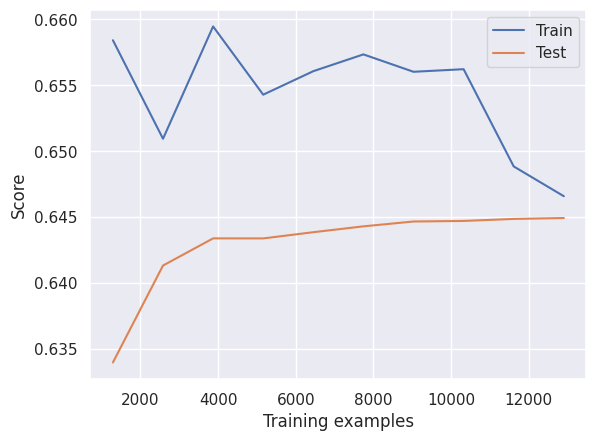

In [29]:
plot_learning_curve(model, X_train_scaled, y_train)

### Модель PolynomialFeatures

In [30]:
poly = PolynomialFeatures(2).set_output(transform="pandas")

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model_poly = LinearRegression().fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)
y_pred_poly = pd.Series(y_pred_poly, index=X_test_poly.index).clip(ymin, ymax)

#### Оцінювання точності моделі

In [31]:
r_sq_upd = model_poly.score(X_train_poly, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_poly)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f"R²: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")

R²: 0.72 | MAE: 0.44 | MAPE: 0.25


In [32]:
r_sq_test = model_poly.score(X_test_poly, y_test)
print(f"R² на тестових даних: {r_sq_test:.2f}")

R² на тестових даних: 0.72


<Axes: xlabel='PRICE', ylabel='None'>

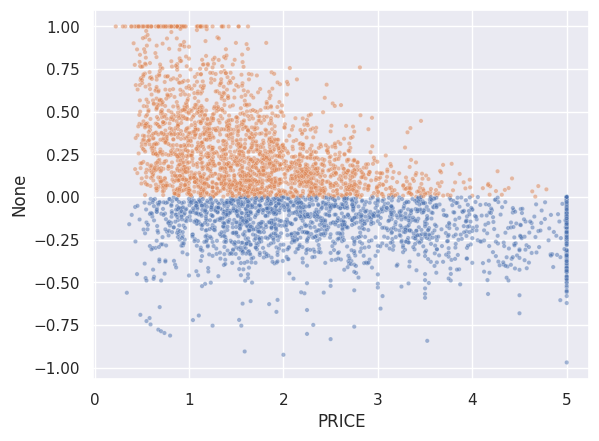

In [33]:
pct_error = (y_pred_poly / y_test - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test, y=pct_error, hue=pct_error.gt(0), alpha=0.5, s=10, legend=False
)

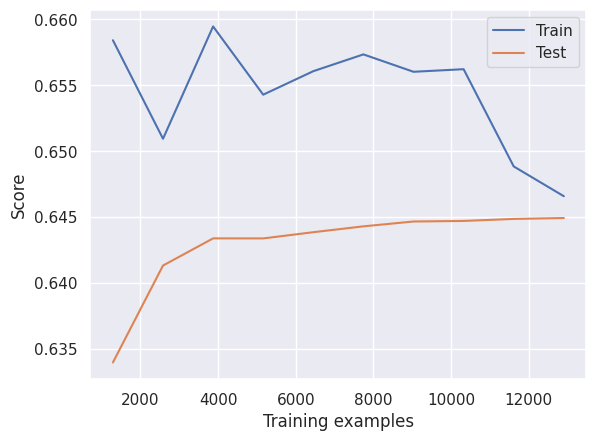

In [34]:
plot_learning_curve(model_poly, X_train_scaled, y_train)

### Модель `Ridge`

In [35]:
# Пошук оптимального параметру alpha за допомогою крос-валідації
alphas = np.logspace(-3, 3, 50)
scores = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    scores.append(score)

best_alpha = alphas[np.argmax(scores)]
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

#### Оцінювання точності моделі

In [36]:
r_sq_upd = final_model.score(X_train_scaled, y_train)
mae_upd = mean_absolute_error(y_test, y_pred)
mape_upd = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")

R²: 0.65 | MAE: 0.50 | MAPE: 0.30


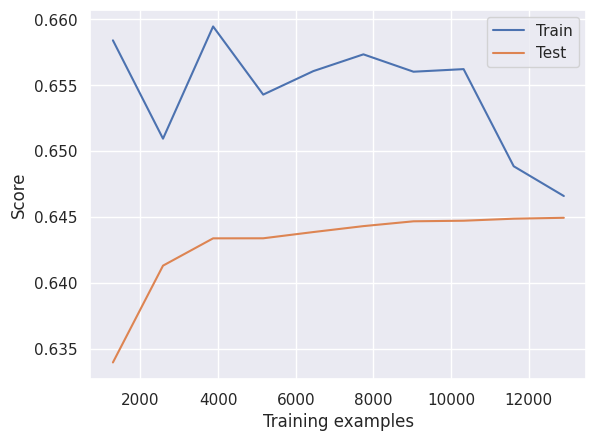

In [37]:
plot_learning_curve(final_model, X_train_scaled, y_train)

<Axes: xlabel='PRICE', ylabel='PRICE'>

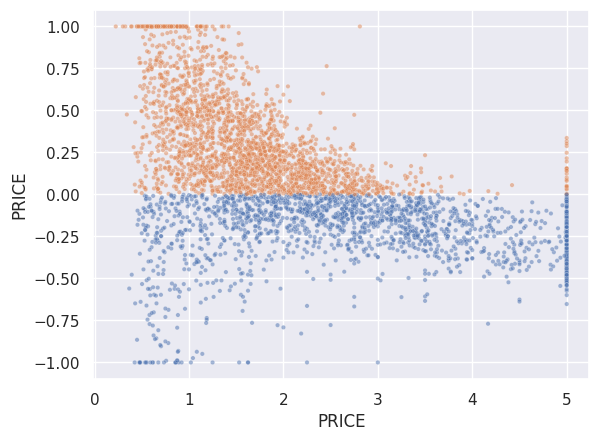

In [38]:
pct_error = (y_pred.squeeze() / y_test.squeeze() - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test.squeeze(), y=pct_error, hue=(pct_error > 0), alpha=0.5, s=10, legend=False
)

## Тестування з використанням PowerTransformer для цільової змінної

In [40]:
def train_and_evaluate_with_pt(df: pd.DataFrame, label: str = TARGET) -> dict:
    X = df.drop(columns=[label])
    y = df[label]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pt = PowerTransformer()

    y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))

    linreg_pt = LinearRegression()
    linreg_pt.fit(X_train, y_train_transformed.ravel())

    y_pred_transformed = linreg_pt.predict(X_test)

    y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1)).ravel()

    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return r2, mae, mape

print("Результати для df_cleaned: ")
r2_cleaned, mae_cleaned, mape_cleaned = train_and_evaluate_with_pt(df_cleaned)
print(f"R²: {r2_cleaned:.2f} | MAE: {mae_cleaned:.2f} | MAPE: {mape_cleaned:.2f}")

print("Результати для df_featured")
r2_featured, mae_featured, mape_featured = train_and_evaluate_with_pt(df_featured)
print(f"R²: {r2_featured:.2f} | MAE: {mae_featured:.2f} | MAPE: {mape_featured:.2f}")

Результати для df_cleaned: 
R²: 0.52 | MAE: 0.51 | MAPE: 0.27
Результати для df_featured
R²: 0.66 | MAE: 0.47 | MAPE: 0.26


## Висновки

- Видалення ознак із високою кореляцією та фільтрація викидів покращили результат: відфільтровано "аномальні" спостереження в `AveRooms`, `Population` і `AveOccup`, а високу мультиколінеарність зменшено приберенням `AveBedrms`.
- Створення нових ознак (логарифмічні, географічні, взаємодія) підвищило точність лінійної регресії на кілька відсотків (до ~`R²`=0.65).
- Поліноміальні ознаки ще суттєвіше підвищили `R²` (понад 0.70), але збільшують ризик перенавчання (потрібно стежити за різницею між `train` і `test`).
- Ridge-регуляризація не дала кращих результатів у цій задачі (`R²` близько 0.65).
- Використання `PowerTransformer` до `y` може зменшити асиметрію та іноді покращити метрики, але ефект вийшов помірним (близько `R²`=0.65 – 0.66).
- Найкращий результат моделі показали після доадавання цільовіх ознак `Price_per_Room` `Value_Density`.
    - R²: 0.96 | MAE: 0.15 | MAPE: 0.10 - для лінійної моделі
    - R²: 1.00 | MAE: 0.00 | MAPE: 0.00 - поліномінальна модель показала ідеальні результати  - що також свідчить про перенавчання.
    - R²: 0.96 | MAE: 0.16 | MAPE: 0.11 - для моделі Ridge

Отже, найбільший внесок у покращення роблять усунення зайвої мультиколінеарності, видалення критичних викидів і додавання адекватних нових ознак.